In [ ]:
import cv2
import random
import numpy as np
from google.colab.patches import cv2_imshow
import copy
import matplotlib.pyplot as plt


In [ ]:
source_image = cv2.imread('painting.png')
height, width = source_image.shape[:2]

# Constants
IMAGE_WIDTH = width
IMAGE_HEIGHT = height
NUM_INDIVIDUALS = 20
NUM_GENES = 50
NUM_GENERATIONS = 10000
MUTATION_PROB = 0.1
NUM_ELITES = round(0.2*NUM_INDIVIDUALS)
TM_SIZE = 5
FRAC_PARENT = 0.6

# Class definitions
class Circle:
    def __init__(self):
        self.x = random.randint(0, IMAGE_WIDTH)
        self.y = random.randint(0, IMAGE_HEIGHT)
        self.radius = random.randint(1, max(IMAGE_WIDTH, IMAGE_HEIGHT) // 2)
        self.color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        self.alpha = random.uniform(0, 1)


    def print(self):
        print(
            "R:",
            self.radius,
            "X:",
            self.x,
            "Y:",
            self.y,
            "RGBA:",
            self.color,
            self.alpha.__round__(2)
        )

class Individual:
    def __init__(self):
        self.chromosome = [Circle() for _ in range(NUM_GENES)]
        self.fitness = float('inf')


def draw_individual(individual):
    image = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.uint8)
    for circle in individual.chromosome:
        overlay = image.copy()
        cv2.circle(overlay, (circle.x, circle.y), circle.radius, circle.color, -1)
        alpha = circle.alpha
        cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
    return image

def evaluate_individual(individual, source_image):

    image = np.ones_like(source_image) * 255

    # Draw each circle (gene) in the individual's chromosome on the image
    for circle in individual.chromosome:
        overlay = image.copy()
        cv2.circle(overlay, (circle.x, circle.y), circle.radius, circle.color, -1)
        alpha = circle.alpha
        image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

    # Calculate the fitness function
    fitness = -np.sum((source_image.astype(np.float32) - image.astype(np.float32)) ** 2)
    return fitness

def selection(population, tm_size):
    # Shuffle the population to prevent bias towards individuals with the same fitness.
    shuffled_population = random.sample(population,len(population))

    # Perform tournament selection
    selected_individuals = []
    for _ in range(NUM_INDIVIDUALS - NUM_ELITES):
        participants = random.sample(shuffled_population, tm_size)
        winner = max(participants, key=lambda ind: ind.fitness)
        selected_individuals.append(winner)

    # Make sure we are returning a new list of individuals, not references to the existing ones
    return [copy.deepcopy(ind) for ind in selected_individuals]



def crossover(parent1, parent2):
    child1, child2 = Individual(), Individual()
    crossover_point = random.randint(0, NUM_GENES)
    child1.chromosome = parent1.chromosome[:crossover_point] + parent2.chromosome[crossover_point:]
    child2.chromosome = parent2.chromosome[:crossover_point] + parent1.chromosome[crossover_point:]
    return child1, child2


def mutate(individual):
    for circle in individual.chromosome:
        if random.random() < MUTATION_PROB:
            if random.random() < 0.5:
                circle.x = random.randint(0, IMAGE_WIDTH)
                circle.y = random.randint(0, IMAGE_HEIGHT)
            if random.random() < 0.5:
                circle.radius = random.randint(1, max(IMAGE_WIDTH, IMAGE_HEIGHT) // 2)
            if random.random() < 0.5:
                circle.color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            if random.random() < 0.5:
                circle.alpha = random.uniform(0, 1)


def clamp(value, min_value, max_value):
    """Ensure that 'value' falls within the range [min_value, max_value]."""
    return max(min_value, min(value, max_value))

def guided_mutation(individual):

    image_width = IMAGE_WIDTH
    image_height = IMAGE_HEIGHT
    for circle in individual.chromosome:
      # Calculate bounds for the mutation
      x_lower_bound = clamp(circle.x - image_width // 4, 0, image_width)
      x_upper_bound = clamp(circle.x + image_width // 4, 0, image_width)

      y_lower_bound = clamp(circle.y - image_height // 4, 0, image_height)
      y_upper_bound = clamp(circle.y + image_height // 4, 0, image_height)

      radius_lower_bound = clamp(circle.radius - 10, 1, max(image_width, image_height) // 2)
      radius_upper_bound = clamp(circle.radius + 10, 1, max(image_width, image_height) // 2)

      # Mutate the circle's properties within the calculated bounds
      circle.x = random.randint(x_lower_bound, x_upper_bound)
      circle.y = random.randint(y_lower_bound, y_upper_bound)
      circle.radius = random.randint(radius_lower_bound, radius_upper_bound)
      circle.color = (
          clamp(circle.color[0] + random.randint(-64, 64), 0, 255),
          clamp(circle.color[1] + random.randint(-64, 64), 0, 255),
          clamp(circle.color[2] + random.randint(-64, 64), 0, 255)
      )
      circle.alpha = clamp(circle.alpha + random.uniform(-0.25, 0.25), 0, 1)

def rank_based_selection(population):
    # Sort the population based on fitness
    sorted_population = sorted(population, key=lambda ind: ind.fitness, reverse=True)
    # Assign selection probabilities based on rank (linear or exponential)
    total_ranks = sum(range(1, len(sorted_population) + 1))
    selection_probabilities = [(len(sorted_population) - rank) / total_ranks for rank in range(len(sorted_population))]
    # Choose individuals based on their assigned probabilities
    selected_indices = np.random.choice(len(sorted_population), size=len(population) - NUM_ELITES, p=selection_probabilities)
    selected_individuals = [sorted_population[index] for index in selected_indices]
    return selected_individuals


Generation: 0 Fitness: -605364900.0
Generation: 100 Fitness: -374713920.0
Generation: 200 Fitness: -370871260.0
Generation: 300 Fitness: -359246180.0
Generation: 400 Fitness: -359246180.0
Generation: 500 Fitness: -359246180.0
Generation: 600 Fitness: -359246180.0
Generation: 700 Fitness: -359246180.0
Generation: 800 Fitness: -359246180.0
Generation: 900 Fitness: -341471040.0
Generation: 1000 Fitness: -324666980.0
Generation: 1100 Fitness: -320395140.0
Generation: 1200 Fitness: -320395140.0
Generation: 1300 Fitness: -320395140.0
Generation: 1400 Fitness: -320395140.0
Generation: 1500 Fitness: -319844700.0
Generation: 1600 Fitness: -319844700.0
Generation: 1700 Fitness: -319844700.0
Generation: 1800 Fitness: -319844700.0
Generation: 1900 Fitness: -319844700.0
Generation: 2000 Fitness: -319844700.0
Generation: 2100 Fitness: -319844700.0
Generation: 2200 Fitness: -319844700.0
Generation: 2300 Fitness: -319844700.0
Generation: 2400 Fitness: -319844700.0
Generation: 2500 Fitness: -319844700.

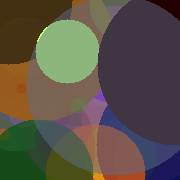

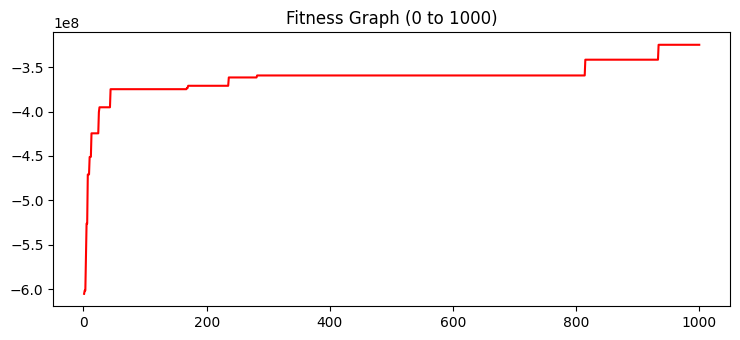

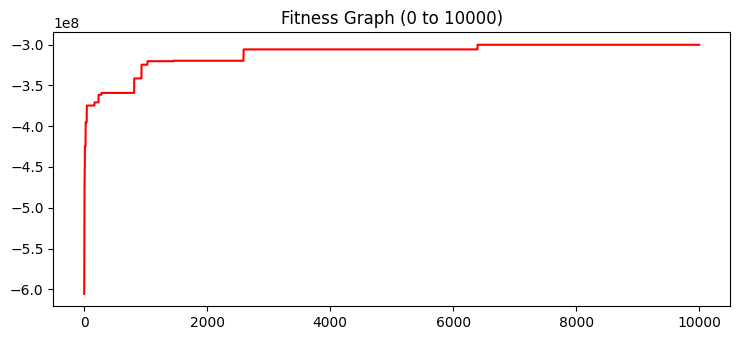

In [ ]:
# Initialize population
population = [Individual() for _ in range(NUM_INDIVIDUALS)]

for individual in population:
    individual.fitness = evaluate_individual(individual, source_image)


# Main evolutionary loop

fitness_values = []

for generation in range(NUM_GENERATIONS):
    # Shuffle and evaluate individuals

    random.shuffle(population)
    for individual in population:
        individual.fitness = evaluate_individual(individual, source_image)

    # Sort by fitness
    population.sort(key=lambda ind: ind.fitness, reverse=True)  # Assuming higher fitness is better

    #save the values
    fitness_values.append(population[0].fitness)
    if generation % 100 == 0:
        print(
            "Generation:",
            generation,
            "Fitness:",
            population[0].fitness,
        )
    if generation % 1000 == 0:
      best_individual = max(population, key=lambda ind: ind.fitness)
      best_image = draw_individual(best_individual)
      file_name = 'best_image_generation_' + str(generation) + '.png'
      cv2.imwrite(file_name, best_image)


    # Elitism
    next_generation = population[:NUM_ELITES]

    # Selection
    selected = selection(population, TM_SIZE)

    # Crossover
    children = []
    num_children = (NUM_INDIVIDUALS - NUM_ELITES) // 2
    for _ in range(num_children):
        parent1, parent2 = random.sample(selected,2)
        child1, child2 = crossover(parent1, parent2)
        children.append(child1)
        children.append(child2)

    # Mutation
    for child in children:
        guided_mutation(child)
        child.fitness = evaluate_individual(child, source_image)

    # Create new generation
    next_generation.extend(children)
    population = next_generation


# The best individual at the end
best_individual = max(population, key=lambda ind: ind.fitness)
best_image = draw_individual(best_individual)
cv2_imshow(best_image)
cv2.imwrite('best_image.png', best_image)


plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

x = np.arange(1, 1001)
y = np.array(fitness_values[:1000])

plt.title("Fitness Graph (0 to 1000)")
plt.plot(x, y, color="red")

plt.savefig('fitness_values_1000.png')
plt.show()

x = np.arange(1, 10001)
y = np.array(fitness_values)

plt.title("Fitness Graph (0 to 10000)")
plt.plot(x, y, color="red")

plt.savefig('fitness_values_10000.png')
plt.show()


# Save or show the best image here using OpenCV


